In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import pano_generator

c:\Users\ual\.conda\envs\felix\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = tf.keras.models.load_model("training_results/last_model/ENB0_All/model")
model.load_weights("training_results/weights/ENB0_All/cp.ckpt")

In [3]:
_,val_ds = pano_generator.get_train_and_val()

In [4]:
model.evaluate(val_ds)

72/72 [==============================] - 7s 36ms/step - loss: 0.0565 - accuracy: 0.9826


[0.056455954909324646, 0.9826388955116272]

In [5]:
inputs = tf.keras.Input([260,260,3])
x = tf.keras.layers.Resizing(224,224) ( inputs)

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor= x)

base.trainable = False
# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)

# Compile
with_out_aug_model = tf.keras.Model(inputs, outputs, name="with_out_aug")
for layer in with_out_aug_model.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [6]:
for old,new in zip(model.layers[2:],with_out_aug_model.layers[1:]):

    with_out_aug_model.get_layer(new.name).set_weights(model.get_layer(old.name).get_weights())
with_out_aug_model.compile(tf.keras.optimizers.Adam(),loss = tf.keras.losses.BinaryCrossentropy(),metrics=["accuracy"])
with_out_aug_model.evaluate(val_ds)

72/72 [==============================] - 4s 38ms/step - loss: 0.0565 - accuracy: 0.9826


[0.056455954909324646, 0.9826388955116272]

In [7]:
test_ds = pano_generator.get_test_ds()
model.evaluate(test_ds)

76/76 [==============================] - 4s 41ms/step - loss: 0.0166 - accuracy: 0.9992


[0.016578298062086105, 0.9991697669029236]

In [8]:
with_out_aug_model.evaluate(test_ds)

76/76 [==============================] - 4s 37ms/step - loss: 0.0166 - accuracy: 0.9992


[0.016578298062086105, 0.9991697669029236]

In [9]:
preds = np.argmax(with_out_aug_model.predict(test_ds),axis=1)
_,val_df,test_df = pano_generator.get_csv()
labels = test_df["pano"].map(int)
failure_mask = preds != labels
failed_images = test_df[failure_mask]
wrong_preds = preds[failure_mask]
wrong_labels = labels[failure_mask]
imgs = np.concatenate([i for i,a in tfds.as_numpy(test_ds)])
len(failed_images)

4

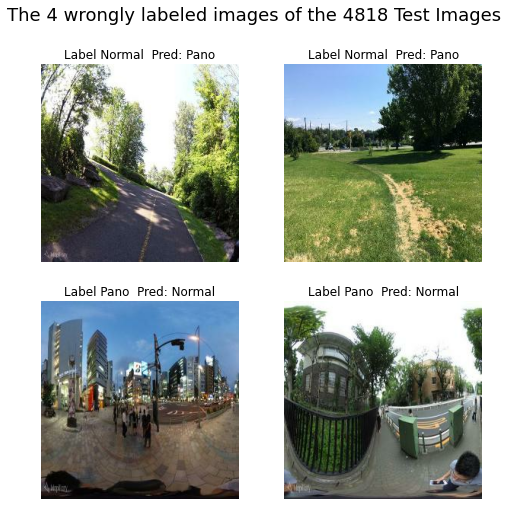

In [10]:
dic = {0:"Normal",1:"Pano"}

fix, axs = plt.subplots(2,2,figsize=(8,8))
axs = axs.flatten()

for i,j in enumerate(failed_images.index):

    axs[i].imshow(imgs[failure_mask][i])
    axs[i].axis('off')
    label = dic[wrong_labels.values[i]]
    pred = dic[wrong_preds[i]]
    axs[i].set_title(f"Label {label}  Pred: {pred}")

plt.suptitle("The 4 wrongly labeled images of the 4818 Test Images",fontsize=18)
plt.savefig("../Imgs/Wrong_Predictions.jpg")
plt.show()

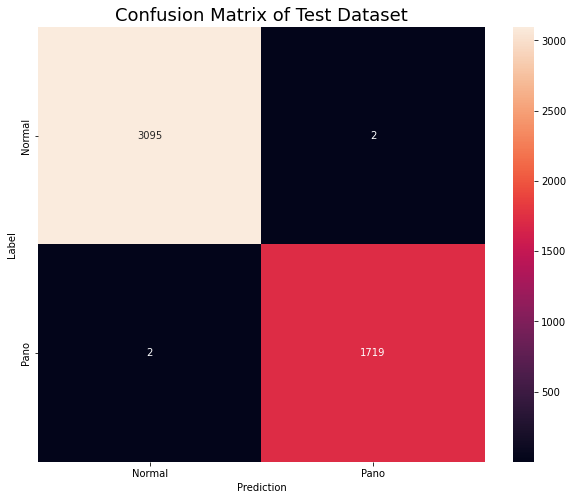

In [11]:
confusion_mtx = tf.math.confusion_matrix(labels,preds)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

names = list(dic.values())

sns.heatmap(confusion_mtx, xticklabels=names, yticklabels=names, 
          annot=True, fmt='g')
plt.title("Confusion Matrix of Test Dataset",fontsize=18)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig("../Imgs/Confusion_Matrix.jpg")
plt.show()

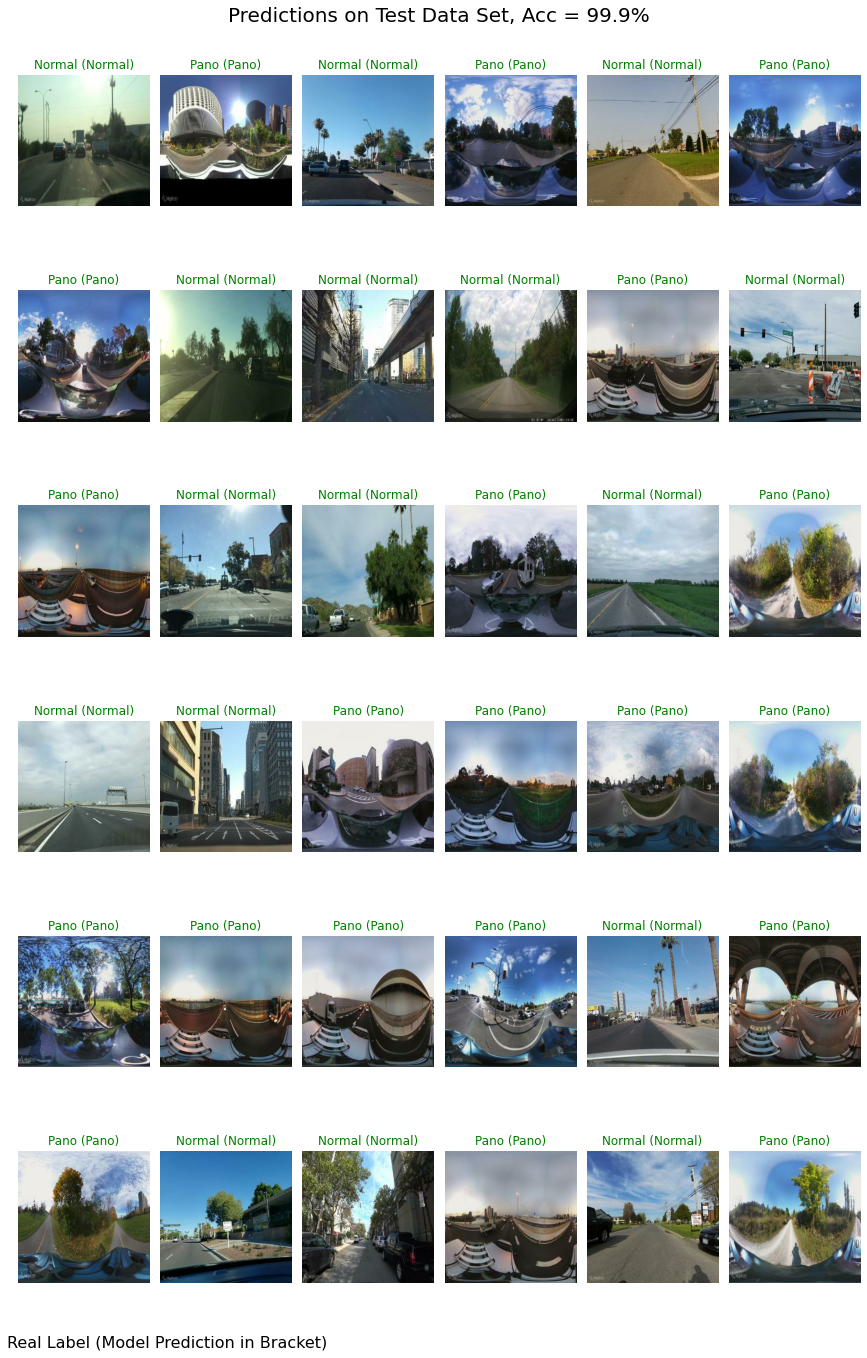

In [12]:
n_row, n_col = 6,6

n_imgs = n_row * n_col

get_names = dic

_, axs = plt.subplots(n_row, n_col, figsize=(12, 19))
axs = axs.flatten()

for i,j in enumerate(np.random.choice(range(len(preds)),n_imgs,replace=False)):
    ax = axs[i]
    
    l = get_names[labels.values[j]]
    p = get_names[preds[j]]
    color = "green" if l==p else "red"
    
    ax.imshow(imgs[j])
    ax.axis("off")
    ax.set_title(f"{l} ({p})",color=color)
    
plt.suptitle("Predictions on Test Data Set, Acc = 99.9%",fontsize=20)
plt.figtext(0,0,"Real Label (Model Prediction in Bracket)",fontsize=16)
plt.tight_layout()
plt.savefig("../Imgs/Predictions.jpg")
plt.show()

In [16]:
os.getcwd()

'c:\\Felix\\SVI_Model_ToolBox\\pano_detection_task\\Training'

In [17]:
model.save("../final_model/pano_model")
with_out_aug_model.save("../final_model_without_aug/")

INFO:tensorflow:Assets written to: ../final_model/pano_model\assets
INFO:tensorflow:Assets written to: ../final_model_without_aug/assets
